In [19]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from prepare_datasets import *
from Helper_functions import *
from prepare_datasets import get_and_prepare_diabetes_dataset

X, y, feature_names, categorical_features, continuous_features, actionable_features= get_and_prepare_diabetes_dataset()


X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_pos = X[y == 1]
X_neg = X[y == 0]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=4)

In [20]:
from Model import NeuralNetwork

model0 = NeuralNetwork(X.shape[1], 200, 2)
model1= NeuralNetwork(X.shape[1], 200, 2)
model2= NeuralNetwork(X.shape[1], 200, 2)
model3= NeuralNetwork(X.shape[1], 200, 2)
model4= NeuralNetwork(X.shape[1], 200, 2)
model5= NeuralNetwork(X.shape[1], 200, 2)
model6= NeuralNetwork(X.shape[1], 200, 2)

In [21]:
models = [model0,model1, model2, model3, model4, model5, model6]
lambdas = [0,0.05,0.1,0.15,0.2,0.25,0.3]

model_path = f"models/diabetes_model_0.pth"
model0.load_state_dict(torch.load(model_path))
model0.eval()

# Load saved weights
for lambda_model, lamda in zip(models[1:], lambdas[1:]):
    model_path = f"models/diabetes_model_lambda_{lamda:.2f}.pth"
    lambda_model.load_state_dict(torch.load(model_path))
    lambda_model.eval()


In [22]:
import torch.nn.functional as F
class WrappedModelForAlibi:
    def __init__(self, model):
        self.model = model
        self.model.eval()

    def predict(self, x):
        with torch.no_grad():
            x_tensor = torch.tensor(x, dtype=torch.float32)
            logits = self.model(x_tensor)

            if logits.ndim == 1:
                logits = logits.unsqueeze(0)

            probs = F.softmax(logits, dim=1)
            return probs.numpy()

## Evaluation using CEM:

In [26]:
import tensorflow as tf
from alibi.explainers import CEM
tf.compat.v1.disable_eager_execution()
from tqdm import tqdm


cost_of_recourses_l1 = []
cost_of_recourses_l2 = []

for (model, lamda ) in zip(models,lambdas):
    print(f"Evaluating using CEM with lambda = {lamda}")

    X_false_negatives, X_true_negatives, _, _ = split_by_classification(model, X_neg)

    X_np = X.numpy()

    predict_fn = WrappedModelForAlibi(model).predict
    # Feature ranges from training data
    feature_min = X_np.min(axis=0)
    feature_max = X_np.max(axis=0)
    feature_range = (feature_min, feature_max)

    cem = CEM(
        predict_fn,
        mode='PN',
        shape=(1, X_np.shape[1]),
        max_iterations=100,
        feature_range = feature_range
    )
    # Fit on a sample of training data (preferably more than 1)
    cem.fit(X_np)


    l1_distances = []
    l2_distances = []

    # Loop over each instance
    for i in tqdm(range(len(X_true_negatives)), desc="Generating CEM counterfactuals"):
        x = X_true_negatives[i:i+1]  # keep shape (1, n_features)
        explanation = cem.explain(x)

        # Extract original and PN (pertinent negative) instance
        original = explanation.data['X'][0]
        pn = explanation.data['PN']

        if pn is not None:
            cf = pn[0]
            l1_distance = torch.norm(original - cf, p=1).item()
            l2_distance = torch.norm(original - cf, p=2).item()
            l1_distances.append(l1_distance)
            l2_distances.append(l2_distance)

    l1_distances = np.array(l1_distances)
    l2_distances = np.array(l2_distances)

    # Compute mean L1 distance
    cost_of_recourses_l1.append(l1_distances)
    cost_of_recourses_l2.append(l1_distances)

    print(f"Mean L1 distance for negatively classified data using DiCE: {np.mean(l1_distances):.2f}")
    print(f"Mean L2 distance for negatively classified data using DiCE: {np.mean(l2_distances):.2f}")

Evaluating using CEM with lambda = 0


Generating CEM counterfactuals:   0%|          | 0/431 [00:00<?, ?it/s]C:\Users\hamma\AppData\Local\Temp\ipykernel_7940\3443672015.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype=torch.float32)
Generating CEM counterfactuals: 100%|██████████| 431/431 [40:52<00:00,  5.69s/it]


Mean L1 distance for negatively classified data using DiCE: 18.82
Mean L2 distance for negatively classified data using DiCE: 11.83
Evaluating using CEM with lambda = 0.05


Generating CEM counterfactuals: 100%|██████████| 453/453 [38:59<00:00,  5.16s/it]


Mean L1 distance for negatively classified data using DiCE: 20.34
Mean L2 distance for negatively classified data using DiCE: 12.70
Evaluating using CEM with lambda = 0.1


Generating CEM counterfactuals: 100%|██████████| 471/471 [42:59<00:00,  5.48s/it]


Mean L1 distance for negatively classified data using DiCE: 23.30
Mean L2 distance for negatively classified data using DiCE: 14.40
Evaluating using CEM with lambda = 0.15


Generating CEM counterfactuals: 100%|██████████| 474/474 [42:51<00:00,  5.43s/it]


Mean L1 distance for negatively classified data using DiCE: 24.94
Mean L2 distance for negatively classified data using DiCE: 15.32
Evaluating using CEM with lambda = 0.2


Generating CEM counterfactuals: 100%|██████████| 477/477 [38:04<00:00,  4.79s/it]


Mean L1 distance for negatively classified data using DiCE: 25.71
Mean L2 distance for negatively classified data using DiCE: 15.44
Evaluating using CEM with lambda = 0.25


Generating CEM counterfactuals: 100%|██████████| 481/481 [38:52<00:00,  4.85s/it]


Mean L1 distance for negatively classified data using DiCE: 21.25
Mean L2 distance for negatively classified data using DiCE: 12.64
Evaluating using CEM with lambda = 0.3


Generating CEM counterfactuals: 100%|██████████| 479/479 [44:16<00:00,  5.55s/it]

Mean L1 distance for negatively classified data using DiCE: 10.33
Mean L2 distance for negatively classified data using DiCE: 6.08


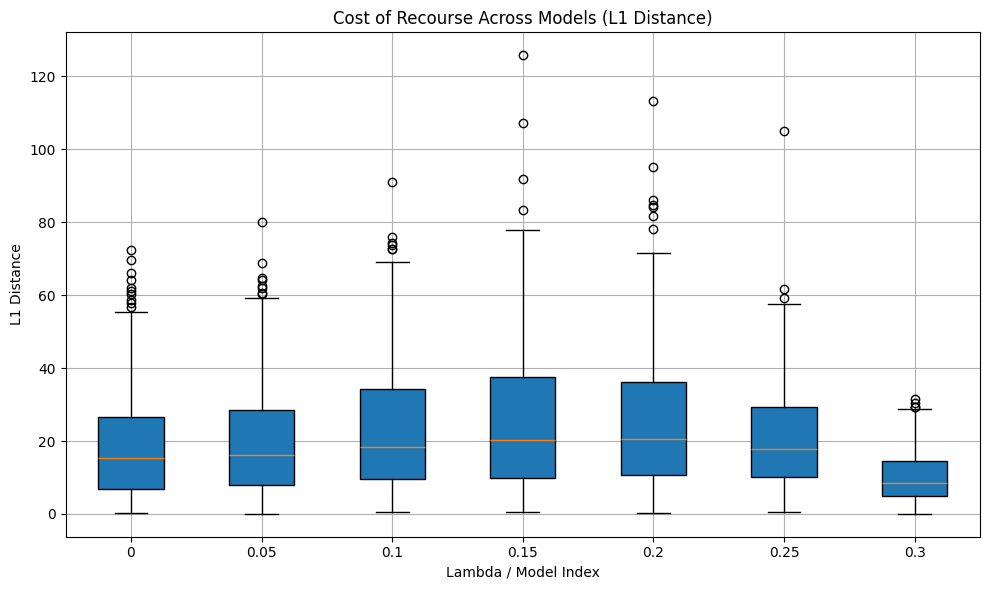

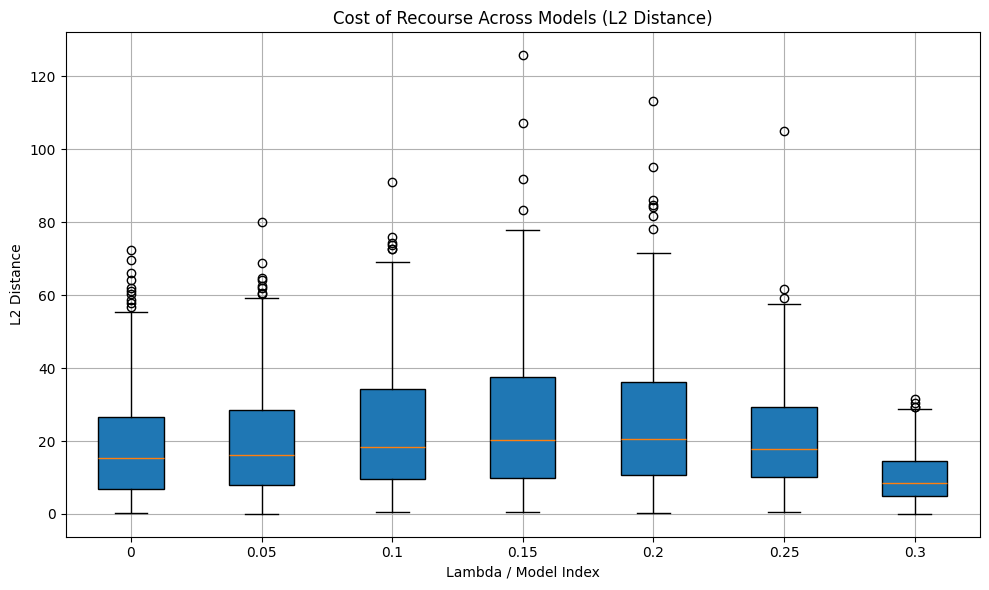

In [28]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(cost_of_recourses_l1,patch_artist=True, tick_labels=lambdas)
plt.title("Cost of Recourse Across Models (L1 Distance)")
plt.xlabel("Lambda / Model Index")
plt.ylabel("L1 Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot(cost_of_recourses_l2,patch_artist=True, tick_labels=lambdas)
plt.title("Cost of Recourse Across Models (L2 Distance)")
plt.xlabel("Lambda / Model Index")
plt.ylabel("L2 Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

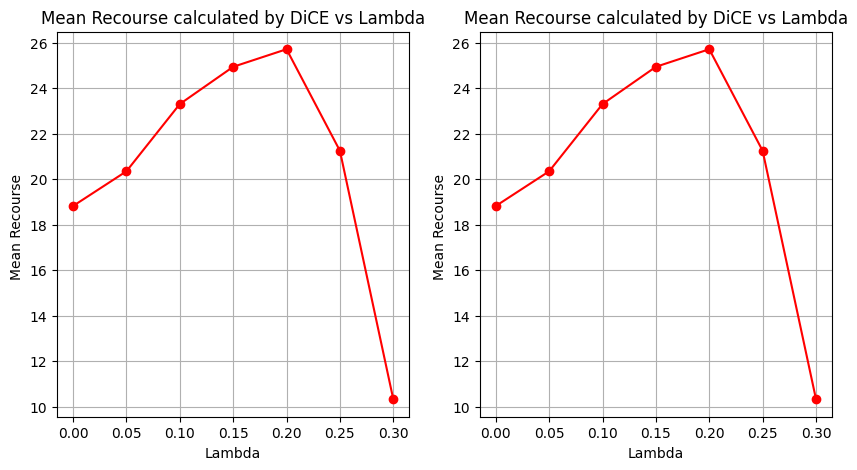

In [29]:
l1_means = [np.mean(sublist) for sublist in cost_of_recourses_l1]
l2_means = [np.mean(sublist) for sublist in cost_of_recourses_l2]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(lambdas, l1_means, marker='o', color='red')
plt.title("Mean Recourse calculated by DiCE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse ")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(lambdas, l2_means, marker='o', color='red')
plt.title("Mean Recourse calculated by DiCE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse ")
plt.grid(True)